# Julia Set

Modified version from [Loic Gouarin](https://github.com/gouarin/GTSage2014/)

[Julia set on wikipedia](https://en.wikipedia.org/wiki/Julia_set)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.rcParams['figure.figsize'] = (6,6)

In [2]:
nx, ny = 512, 512 # mesh
lim, maxit = 400, 2000 # limits 
vmin, vmax = 0, 200 

x = np.linspace(-1.6, 1.6, nx)
y = np.linspace(-1.6, 1.6, ny)
c = -0.772691322542185 + 0.124281466072787j

# Pure Python

In [3]:
def juliaset_python(x, y, c, lim, maxit):
    """ 
    returns Julia set
    """
    julia = np.zeros((x.size, y.size))

    for i in range(x.size):
        for j in range(y.size):
            z = x[i] + 1j*y[j]
            ite = 0
            while abs(z) < lim and ite < maxit:
                z = z**2 + c
                ite += 1
            julia[j, i] = ite

    return julia

In [4]:
def plot_julia_set(julia):
    plt.figure(figsize=(6,6))
    plt.imshow(julia, cmap = cm.Greys, vmin=vmin, vmax=vmax)

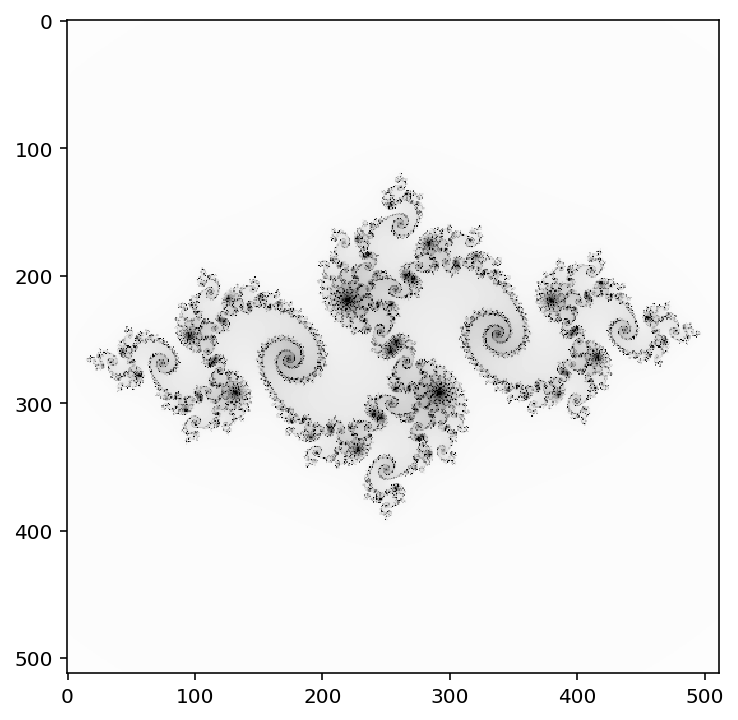

In [5]:
plot_julia_set(juliaset_python(x, y, c, lim, maxit))

# Fortran

In [6]:
%load_ext fortranmagic


/opt/miniconda3/lib/python3.6/site-packages/fortranmagic.py:147: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module since IPython 4.0.
  self._lib_dir = os.path.join(get_ipython_cache_dir(), 'fortran')


In [7]:
%%fortran --f90flags "-O3 -fopenmp" --extra "-L/usr/local/lib -lgomp"
subroutine juliaset_fortran(x, y, c, lim, maxit, julia)

    real(8),    intent(in)  :: x(:)
    real(8),    intent(in)  :: y(:)
    complex(8), intent(in)  :: c
    real(8),    intent(in)  :: lim
    integer,    intent(in)  :: maxit
    integer,    intent(out) :: julia(size(x),size(y))

    real(8)    :: zr, zi, limsq, cr, ci, tmp
    complex(8) :: z
    integer    :: ite, nx, ny

    nx = size(x)
    ny = size(y)
    limsq = lim * lim
    cr = real(c)
    ci = imag(c)

    !$OMP PARALLEL DEFAULT(NONE) &
    !$OMP FIRSTPRIVATE(nx,ny,x,y,c,limsq,maxit,cr,ci) &
    !$OMP PRIVATE(i,j,ite,zr,zi, tmp) &
    !$OMP SHARED(julia)
    !$OMP DO SCHEDULE(DYNAMIC)
    do i = 1, nx
       do j = 1, ny   
            zr = x(i)
            zi = y(j)
            ite = 0
            do while (zr*zr+zi*zi < limsq .and. ite < maxit)
                tmp = zr*zr - zi*zi 
                zi = 2*zr*zi + ci
                zr = tmp + cr
                ite = ite + 1
            end do
            julia(j, i) = ite
        end do
    end do
    
    !$OMP END PARALLEL


end subroutine juliaset_fortran

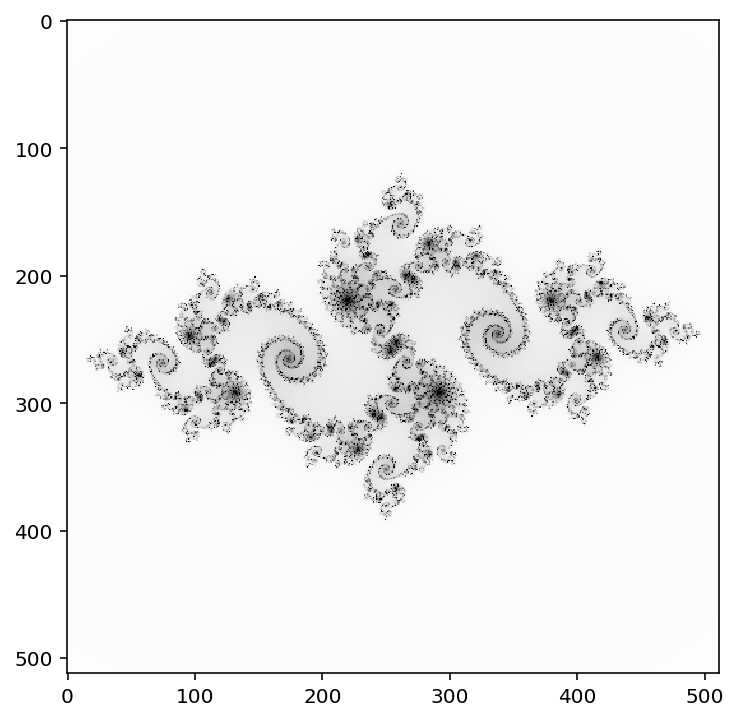

In [8]:
plot_julia_set(juliaset_fortran(x, y, c, lim, maxit))

# Numpy

In [9]:
import itertools

def juliaset_numpy(x, y, c, lim, maxit):
    julia = np.zeros((x.size, y.size), dtype=np.int32)

    zx = x[np.newaxis, :]
    zy = y[:, np.newaxis]
    
    z = zx + zy*1j
    
    for ite in itertools.count():
        
        z = z**2 + c 
        mask = np.logical_not(julia) & (np.abs(z) >= lim)
        julia[mask] = ite
        if np.all(julia) or ite > maxit:
            return julia
            

    

/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in square
  del sys.path[0]
/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in square
  del sys.path[0]
/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in absolute
  
/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater_equal
  


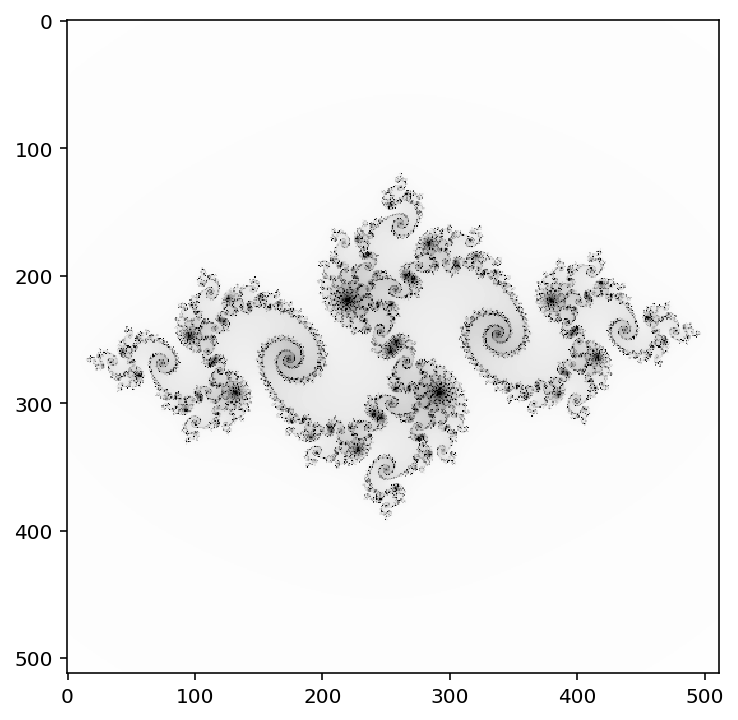

In [10]:
plot_julia_set(juliaset_numpy(x, y, c, lim, maxit))

# Cython

In [11]:
%load_ext cython
%env CC=gcc

env: CC=gcc


In [12]:
%%cython
import numpy as np
import cython

@cython.boundscheck(False)
@cython.wraparound(False)
def juliaset_cython(double [:] x, double [:] y, double complex c, double lim, int maxit):
    cdef:
        int [:, ::1] julia = np.zeros((x.size, y.size), dtype = np.int32)
        double tmp, zr, zi, lim2 = lim*lim
        double cr = c.real, ci = c.imag
        int ite, i, j, nx=x.size, ny=y.size

    for i in range(nx):
        for j in range(ny):
            zr = x[i] 
            zi = y[j]
            ite = 0
            while (zr*zr + zi*zi) < lim2 and ite < maxit:
                zr, zi = zr*zr - zi*zi + cr, 2*zr*zi + ci
                ite += 1
            julia[j, i] = ite

    return julia

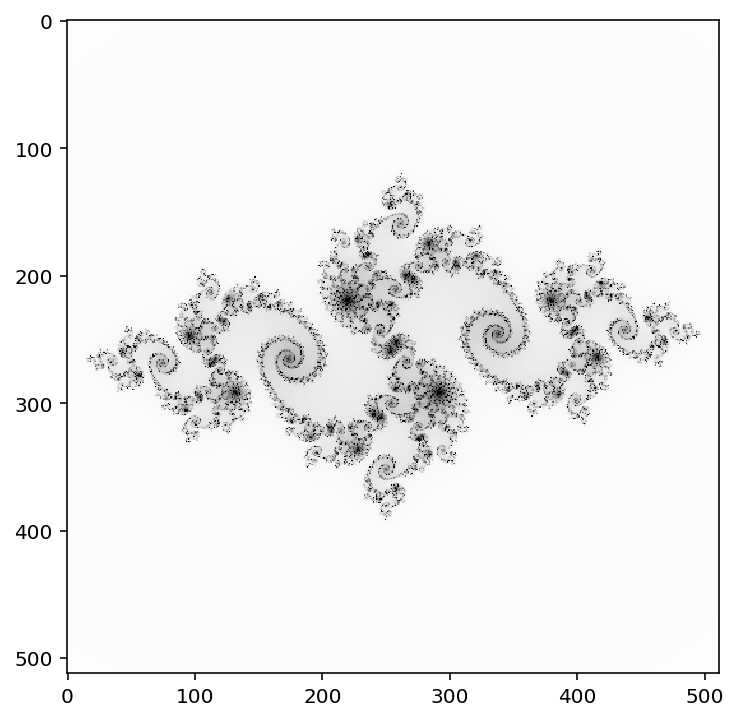

In [13]:
plot_julia_set(juliaset_cython(x, y, c, lim, maxit))

In [14]:
%%cython -f -c-fopenmp --link-args=-fopenmp
import numpy as np
import cython
from cython.parallel import prange
from libc.stdlib cimport malloc, free 

@cython.boundscheck(False)
@cython.wraparound(False)
def juliaset_cython_omp(double [:] x, double [:] y, double complex c, double lim, int maxit):
    cdef:
        int [:, ::1] julia = np.zeros((x.size, y.size), dtype = np.int32)
        double tmp, zr, zi, lim2 = lim*lim
        double cr = c.real, ci = c.imag
        int  i, j, nx=x.size, ny=y.size
        int *ite

    for j in prange(ny, nogil=True, schedule='dynamic'):
        ite = <int *> malloc(sizeof(int))
        for i in range(nx):
            zr = x[i] 
            zi = y[j]
            ite[0] = 0
            while (zr*zr + zi*zi) < lim2 and ite[0] < maxit:
                zr, zi = zr*zr - zi*zi + cr, 2*zr*zi + ci
                ite[0] += 1
            julia[j, i] = ite[0]
        free(ite)
        
    return julia

/home/pnavaro/.cache/ipython/cython/_cython_magic_9abe17c7fa0fa9d4ceff171dd40ce691.c: In function ‘__pyx_pf_46_cython_magic_9abe17c7fa0fa9d4ceff171dd40ce691_juliaset_cython_omp._omp_fn.0’:
/home/pnavaro/.cache/ipython/cython/_cython_magic_9abe17c7fa0fa9d4ceff171dd40ce691.c:2341:29: warning: ‘__pyx_v_zr’ may be used uninitialized in this function [-Wmaybe-uninitialized]
                     #pragma omp for lastprivate(__pyx_v_i) lastprivate(__pyx_v_ite) firstprivate(__pyx_v_j) lastprivate(__pyx_v_j) lastprivate(__pyx_v_zi) lastprivate(__pyx_v_zr) schedule(dynamic)
                             ^~~
/home/pnavaro/.cache/ipython/cython/_cython_magic_9abe17c7fa0fa9d4ceff171dd40ce691.c:2175:10: note: ‘__pyx_v_zr’ was declared here
   double __pyx_v_zr;
          ^~~~~~~~~~
/home/pnavaro/.cache/ipython/cython/_cython_magic_9abe17c7fa0fa9d4ceff171dd40ce691.c:2341:29: warning: ‘__pyx_v_zi’ may be used uninitialized in this function [-Wmaybe-uninitialized]
                     #pragma omp for las

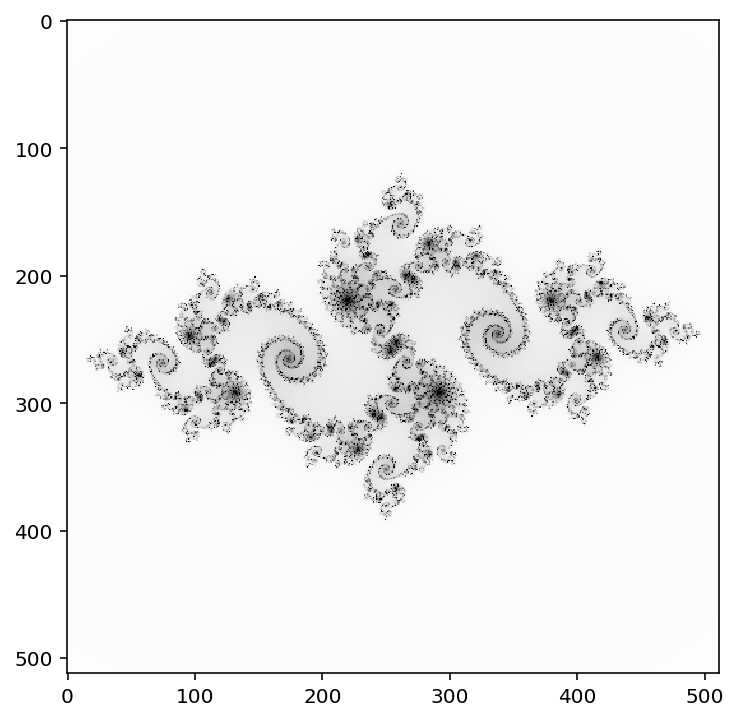

In [15]:
plot_julia_set(juliaset_cython_omp(x, y, c, lim, maxit))

# numba

In [16]:
from numba import autojit

@autojit
def juliaset_numba(x, y, c, lim, maxit):
    julia = np.zeros((x.size, y.size))
    lim2 = lim*lim
    
    c = complex(c)  # needed for numba
    for j in range(y.size):
        for i in range(x.size):

            z = complex(x[i], y[j])
            ite = 0
            while (z.real*z.real + z.imag*z.imag) < lim2 and ite < maxit:
                z = z*z + c
                ite += 1
            julia[j, i] = ite

    return julia

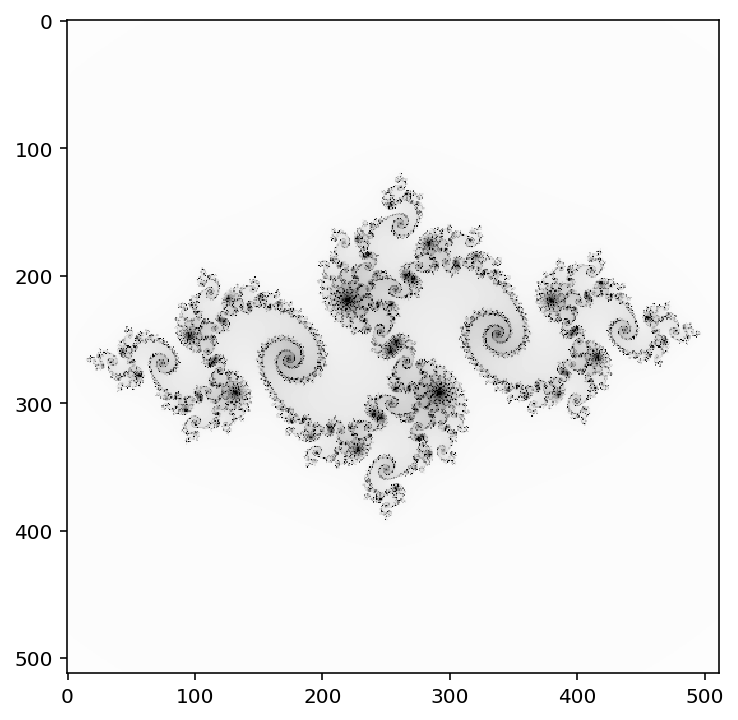

In [17]:
plot_julia_set(juliaset_numba(x, y, c, lim, maxit))

In [18]:
%load_ext pythran.magic

In [19]:
%%pythran -fopenmp

import numpy as np

#pythran export juliaset_pythran(float64[], float64[],complex, int, int)
def juliaset_pythran(x, y, c, lim, maxit):
    """ 
    returns Julia set
    """
    julia = np.zeros((x.size, y.size), dtype=np.int32)

    #omp parallel for private(z)
    for j in range(y.size):
        for i in range(x.size):
            z = x[i] + 1j*y[j]
            ite = 0
            while abs(z) < lim and ite < maxit:
                z = z**2 + c
                ite += 1
            julia[j, i] = ite

    return julia

/opt/miniconda3/lib/python3.6/site-packages/pythran/interval.py:90: RuntimeWarning: invalid value encountered in double_scalars
  return Interval(self.low + other.low, self.high + other.high)


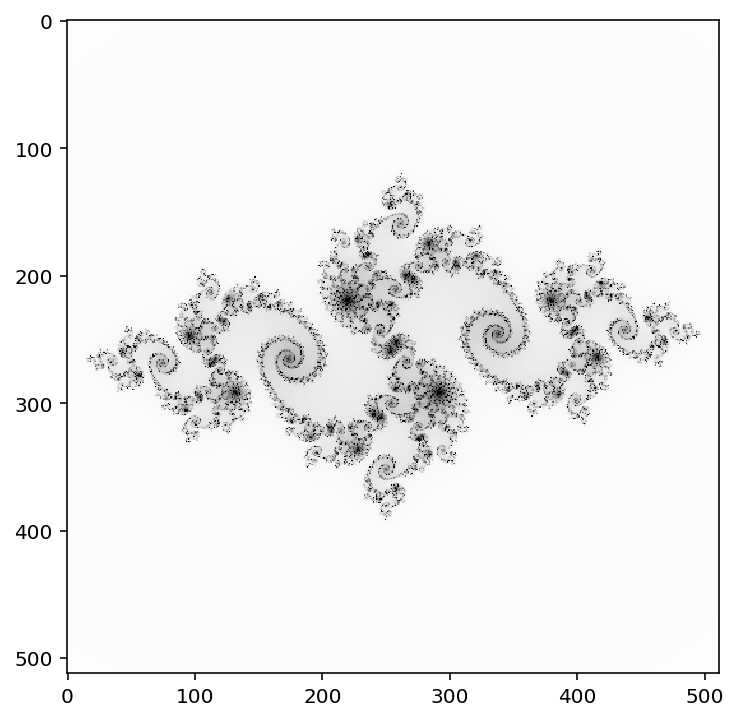

In [20]:
plot_julia_set(juliaset_pythran(x, y, c, lim, maxit))

In [21]:
import pandas as pd
from collections import defaultdict
results = defaultdict(list)

functions = [juliaset_python,
             juliaset_fortran,
             juliaset_numpy,
             juliaset_cython,
             juliaset_cython_omp,
             juliaset_numba,
             juliaset_pythran]

for f in functions:

    _ = %timeit -oq -n 1 f(x, y, c, lim, maxit)
    results['etime'] += [_.best]

/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in square
  del sys.path[0]
/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in square
  del sys.path[0]
/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in absolute
  
/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater_equal
  


In [22]:
results = pd.DataFrame(results, index=list(map(lambda f:f.__name__[9:],functions)))


In [23]:
results["speed_up"] = [results.etime[0]/t for t in results.etime]

In [24]:
results.sort_values(by="speed_up",axis=0)

,etime,speed_up
python,3.610251,1.000000
numpy,1.401570,2.575862
pythran,0.021013,171.808328
numba,0.014537,248.351783
cython,0.013732,262.909732
cython_omp,0.003749,962.983669
fortran,0.003713,972.218265
